In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

# Coupling From The Past (CFTP) Algorithm Implementation

## 1. Introduction

Coupling From The Past (CFTP) is a perfect sampling algorithm introduced by Propp and Wilson (1996) that generates samples exactly from a target distribution. Unlike standard MCMC methods that require a burn-in period and only produce approximate samples, CFTP guarantees exactness.

The key idea behind CFTP is to start multiple Markov chains from all possible states in the past and run them forward until the present. When all chains coalesce to the same state, that state is a perfect sample from the target distribution.

## 2. Mathematical Background

In MCMC sampling, we typically have:

$$E = \sum_{i=1}^{m+1} w_i / \sum_{i=1}^{m+2} w_i$$

For all $w_1,...,w_{m+2}$ iid $\mathcal{L}ep(1)$ (Laplace distribution with scale parameter 1), we notice that if we use a common vector $(w_1^{(t)},...,w_{m+2}^{(t)})$ for all parallel chains, we can exhibit a monotone structure associated with the transition kernel.

This allows us to monitor just two chains:
- One starting with the minimum possible state
- One starting with the maximum possible state

If these two "extreme" chains coalesce, then all chains starting from any intermediate state would have coalesced as well.

## 3. Implementation of the CFTP Algorithm

```python
import random
import math

class CFTPSampler:
    """
    Implementation of the Coupling From The Past (CFTP) algorithm
    for perfect sampling from a target distribution using only standard Python.
    """
    
    def __init__(self, min_state, max_state, max_doubling=20, random_seed=None):
        """
        Initialize the CFTP sampler.
        
        Parameters:
        -----------
        min_state : float or int
            The minimum possible state value (for bounding sequence)
        max_state : float or int
            The maximum possible state value (for bounding sequence)
        max_doubling : int
            Maximum number of doubling iterations
        random_seed : int
            Random seed for reproducibility
        """
        self.min_state = min_state
        self.max_state = max_state
        self.max_doubling = max_doubling
        
        if random_seed is not None:
            random.seed(random_seed)
    
    def _box_muller_transform(self):
        """
        Generate standard normal random variables using Box-Muller transform.
        """
        u1 = random.random()
        u2 = random.random()
        
        z0 = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
        return z0
    
    def _laplace_random(self, scale=1.0):
        """
        Generate a random number from Laplace(0, scale) distribution.
        """
        u = random.random() - 0.5
        return -scale * math.copysign(1, u) * math.log(1 - 2 * abs(u))
    
    def _generate_common_random_numbers(self, size):
        """
        Generate common random numbers to use for coupling.
        """
        return [random.random() for _ in range(size)]
    
    def monotone_transition_kernel(self, current_state, random_number, step_size=1.0):
        """
        A monotone transition kernel that preserves ordering.
        For states x ≤ y, we ensure that T(x, random_number) ≤ T(y, random_number)
        """
        # Using the random number to determine a step in a way that preserves monotonicity
        if random_number < 0.5:
            # Move left with probability 0.5
            step = -step_size * math.log(2 * random_number) if random_number > 0 else -step_size * 10
        else:
            # Move right with probability 0.5
            step = step_size * math.log(2 * (1 - random_number)) if random_number < 1 else step_size * 10
        
        new_state = current_state + step
        
        # Ensure we stay within bounds with reflection
        if new_state < self.min_state:
            new_state = 2 * self.min_state - new_state  # Reflection at minimum
        elif new_state > self.max_state:
            new_state = 2 * self.max_state - new_state  # Reflection at maximum
            
        return max(min(new_state, self.max_state), self.min_state)  # Ensure bounds are respected
    
    def sample(self):
        """
        Generate a single perfect sample using CFTP.
        
        Returns:
        --------
        sample : float or int
            A single sample from the target distribution
        coalescence_time : int
            The time (negative) at which coalescence occurred
        path_history : dict
            Dictionary containing the paths of the upper and lower chains
        """
        # Start with a short time interval and double until coalescence
        T = 1
        path_history = {'upper': [], 'lower': []}
        
        for doubling in range(self.max_doubling):
            # Double the time interval
            T *= 2
            
            # Initialize the upper and lower chains at time -T
            lower_chain = self.min_state
            upper_chain = self.max_state
            
            # Store the paths
            lower_path = [lower_chain]
            upper_path = [upper_chain]
            
            # Generate common random numbers for all iterations
            random_numbers = self._generate_common_random_numbers(T)
            
            # Run the chains forward from time -T to 0
            for t in range(T):
                # Use the same random number for both chains
                rnd = random_numbers[t]
                
                # Update both chains using the transition kernel
                lower_chain = self.monotone_transition_kernel(lower_chain, rnd)
                upper_chain = self.monotone_transition_kernel(upper_chain, rnd)
                
                # Store the states
                lower_path.append(lower_chain)
                upper_path.append(upper_chain)
                
                # Check for coalescence
                if abs(lower_chain - upper_chain) < 1e-10:  # Using small epsilon for float comparison
                    if t == T - 1:  # Coalescence at time 0
                        path_history['upper'] = upper_path
                        path_history['lower'] = lower_path
                        return lower_chain, -T + t, path_history
            
        # If we reach here, we didn't achieve coalescence within max_doubling
        raise RuntimeError(f"Failed to achieve coalescence after {self.max_doubling} doubling iterations")
```

## 4. Distribution Classes

### 4.1 Laplace Distribution

The Laplace distribution (double exponential distribution) has the probability density function:

$$f(x|\mu,b) = \frac{1}{2b} \exp\left(-\frac{|x-\mu|}{b}\right)$$

where $\mu$ is the location parameter and $b$ is the scale parameter.

```python
class LaplaceDistribution:
    """
    Implementation of the Laplace (double exponential) distribution
    """
    def __init__(self, loc=0, scale=1):
        self.loc = loc
        self.scale = scale
    
    def pdf(self, x):
        """Probability density function"""
        return (1 / (2 * self.scale)) * math.exp(-abs(x - self.loc) / self.scale)
    
    def sample(self):
        """Generate a random sample"""
        u = random.random() - 0.5
        return self.loc - self.scale * math.copysign(1, u) * math.log(1 - 2 * abs(u))
```

### 4.2 Normal Distribution

The Normal distribution has the probability density function:

$$f(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)$$

```python
class NormalDistribution:
    """
    Implementation of the Normal distribution
    """
    def __init__(self, mean=0, std_dev=1):
        self.mean = mean
        self.std_dev = std_dev
    
    def pdf(self, x):
        """Probability density function"""
        return (1 / (self.std_dev * math.sqrt(2 * math.pi))) * \
               math.exp(-0.5 * ((x - self.mean) / self.std_dev) ** 2)
    
    def sample(self):
        """Generate a random sample using Box-Muller transform"""
        u1 = random.random()
        u2 = random.random()
        
        z0 = math.sqrt(-2.0 * math.log(u1)) * math.cos(2.0 * math.pi * u2)
        return self.mean + self.std_dev * z0
```

### 4.3 Mixture Distribution

A mixture distribution is a probabilistic model where the data comes from a mixture of different probability distributions:

$$f(x) = \sum_{i=1}^{k} w_i f_i(x)$$

where $w_i$ are the mixture weights such that $\sum_{i=1}^{k} w_i = 1$ and $f_i(x)$ are the component distributions.

```python
class MixtureDistribution:
    """
    Implementation of a mixture distribution
    """
    def __init__(self, distributions, weights):
        self.distributions = distributions
        self.weights = weights
        # Normalize weights
        total = sum(weights)
        self.weights = [w / total for w in weights]
        
    def pdf(self, x):
        """Probability density function"""
        return sum(w * d.pdf(x) for w, d in zip(self.weights, self.distributions))
    
    def sample(self):
        """Generate a random sample"""
        # Choose a component based on weights
        u = random.random()
        cumulative = 0
        for i, weight in enumerate(self.weights):
            cumulative += weight
            if u <= cumulative:
                return self.distributions[i].sample()
        return self.distributions[-1].sample()  # Fallback
```

## 5. Running the Simulation

```python
def run_simulation():
    """
    Run a simulation to demonstrate the CFTP algorithm
    """
    # Create a mixture distribution as mentioned in the paper
    # Mixture of N(3, 2.3) and N(11, 3.3) with weights 0.33 and 0.67
    normal1 = NormalDistribution(3, 2.3)
    normal2 = NormalDistribution(11, 3.3)
    mixture = MixtureDistribution([normal1, normal2], [0.33, 0.67])
    
    # Create the CFTP sampler
    cftp = CFTPSampler(min_state=-10, max_state=20, random_seed=42)
    
    # Generate samples
    num_samples = 495  # as in the figure mentioned in the paper
    samples = []
    coalescence_times = []
    
    for i in range(num_samples):
        try:
            sample, coalescence_time, _ = cftp.sample()
            samples.append(sample)
            coalescence_times.append(coalescence_time)
            if i % 50 == 0:
                print(f"Generated {i} samples")
        except RuntimeError as e:
            print(f"Error at sample {i}: {e}")
    
    # Print summary statistics
    print(f"Generated {len(samples)} samples")
    
    # Calculate mean and variance
    mean = sum(samples) / len(samples)
    variance = sum((x - mean) ** 2 for x in samples) / len(samples)
    
    print(f"Sample mean: {mean}")
    print(f"Sample variance: {variance}")
    print(f"Theoretical mean: {0.33 * 3 + 0.67 * 11}")
    
    # Calculate histogram (simple version)
    min_val = min(samples)
    max_val = max(samples)
    num_bins = 20
    bin_width = (max_val - min_val) / num_bins
    bins = [0] * num_bins
    
    for sample in samples:
        bin_index = min(int((sample - min_val) / bin_width), num_bins - 1)
        bins[bin_index] += 1
    
    print(f"Histogram (simple):")
    for i, count in enumerate(bins):
        bin_start = min_val + i * bin_width
        bin_end = min_val + (i + 1) * bin_width
        print(f"Bin [{bin_start:.2f}, {bin_end:.2f}): {count}")
    
    # Calculate coalescence time statistics
    avg_coal_time = sum(coalescence_times) / len(coalescence_times)
    min_coal_time = min(coalescence_times)
    max_coal_time = max(coalescence_times)
    
    print(f"Average coalescence time: {avg_coal_time}")
    print(f"Min coalescence time: {min_coal_time}")
    print(f"Max coalescence time: {max_coal_time}")
    
    return samples, coalescence_times

# Run the simulation
if __name__ == "__main__":
    samples, coalescence_times = run_simulation()
```

## 6. The Sandwiching Argument

As mentioned in Kendall (1998) and Kendall and Møller (1999, 2000), the monotonicity requirement can be weakened into an envelope or sandwiching argument. If we can find two sequences $(\underline{\theta}_t)$ and $(\overline{\theta}_t)$ generated from a transition not necessarily associated with the target distribution $\pi$, such that for any starting value $\theta_0$:

$$\underline{\theta}_t \preceq \phi_t(\theta_0) \preceq \overline{\theta}_t$$

Then the coalescence of the two bounding sequences $\underline{\theta}$ and $\overline{\theta}$ implies coalescence of all chains starting from any possible values of $\theta$.

In our implementation, we use:
- $\underline{\theta}_0 = $ `min_state` (lower bound)
- $\overline{\theta}_0 = $ `max_state` (upper bound)

## 7. Visualization Example

In a standard implementation with visualization libraries, we would create plots similar to Figure 13.2 from the reference text:

1. The left plot would show all chains from different starting points converging to the same value, illustrating coalescence
2. The right plot would show a histogram of samples compared to the theoretical density of the target distribution

Since we're avoiding external libraries, we've implemented a simple text-based histogram in the code above.

## 8. Conclusion

The CFTP algorithm provides a way to generate perfect samples from a target distribution without having to worry about burn-in periods or convergence diagnostics. The key insight is to run chains backward in time until we achieve coalescence, which guarantees that the sample we obtain is exactly from the target distribution.

This implementation demonstrates how to create a pure Python implementation of CFTP without relying on external libraries.

# Enveloping Results in MCMC Methods

## Enveloping Property in the Gibbs Transition

In this setting, Hobert et al. (1999) have, however, obtained an enveloping result, namely that the image of the triangle of all possible starting values of $(n_1, n_2)$,

$$T = \{(n_1, n_2): n_1 + n_2 \leq s\}$$

by the corresponding Gibbs transition is contained in the lozenge$^4$

$$\mathcal{L} = \{(n_1, n_2): \underline{n}_1 \leq n_1 \leq \overline{n}_1, \, n_2 \geq 0, \, \underline{n}_2 \leq n + n_1 - n_2 \leq \overline{n}_2\},$$

where
- $\underline{n}_1$ is the minimum of the $n_1$'s over the images of the left border of $T$;
- $\overline{n}_1$ is the $n_1$ coordinate of the image of $(s, 0)$;
- $\underline{n}_2$ is the $n_1$ coordinate of the image of $(0, 0)$;
- $\overline{n}_2$ is the minimum of the $n_2$'s over the images of the diagonal of $T$.

The reason for this property is that, for a fixed $n_2$,

$$\frac{p_2}{p_1 + p_2} = \sum_{j=1}^{n_1+n_2} w_{2j} / \sum_{j=1}^{n_1+n_2} w_{1j} \quad \text{and} \quad \frac{p_1}{p_1 + p_2} = \sum_{j=1}^{n_1+n_2} w_{1j} / \sum_{j=1}^{n_1+n_2} w_{1j}$$

are both decreasing in $n_1$. And this is also true for

$$m_1 = \sum_{i=1}^{s}\left(u_i \leq \left[1 + \frac{p_2 f_2(x_i) + p_3 f_3(x_i)}{p_1 f_1(x_i)}\right]^{-1}\right)$$

Besides, this bounding property is preserved over iterations, in that the image of $\mathcal{L}$ is contained in

$$\mathcal{L'} = \{(m_1, m_2): \underline{m}_1 \leq m_1 \leq \overline{m}_1, \, m_2 \geq 0, \, \underline{m}_2 \leq m_2 \leq \overline{m}_2\},$$

where
- $\underline{m}_1$ is the minimum of $m_1$ over the images of the left border $\{n_1 = \underline{n}_1\}$;
- $\overline{m}_1$ is the maximum of $m_1$ over the images of the right border $\{n_1 = \overline{n}_1\}$;
- $\underline{m}_2$ is the minimum of $m_2$ over the images of the upper border $\{n_2 = \overline{n}_2\}$;
- $\overline{m}_2$ is the maximum of $m_2$ over the images of the lower border $\{n_2 = \underline{n}_2\}$.

Therefore, checking for coalescence simplifies into monitoring the successive lozenges $\mathcal{L}$ until they reduce to a single point. Figure 13.3 represents a few successive steps in this monitoring, with the original chains provided as a comparison. It illustrates the obvious point that coalescence will consume more iterations than direct monitoring of the chains, while requiring only a $\mathcal{O}(1)$ computational effort at each iteration, compared with the better loose $\mathcal{O}(n^2)$ effort of the direct sandwiching.

---

$^4$ A lozenge is a figure with four equal sides and two obtuse angles and, more commonly, a diamond-shaped candy used to suppress a cough, a "cough-drop."

## Implementing the Enveloping Approach



## Mathematical Analysis of the Approach

The key insight from Hobert et al. (1999) is that instead of tracking all possible chains (which would be computationally expensive), we can track the bounds of a region (the lozenge) that contains all possible states. As we apply the Gibbs transition repeatedly, this region should shrink until it eventually reduces to a single point, indicating coalescence.

The ratio expressions:

$$\frac{p_2}{p_1 + p_2} = \sum_{j=1}^{n_1+n_2} w_{2j} / \sum_{j=1}^{n_1+n_2} w_{1j}$$

and

$$\frac{p_1}{p_1 + p_2} = \sum_{j=1}^{n_1+n_2} w_{1j} / \sum_{j=1}^{n_1+n_2} w_{1j}$$

being decreasing in $n_1$ is crucial for establishing the monotonicity properties that allow us to track only the boundaries.

## Comparison with Direct Chain Monitoring

As noted in the text, while this approach may require more iterations to detect coalescence compared to direct monitoring of chains, it has a significant computational advantage:

1. Direct chain monitoring: $\mathcal{O}(n^2)$ computational effort per iteration
2. Enveloping approach: $\mathcal{O}(1)$ computational effort per iteration

For large state spaces, this computational advantage outweighs the potential increase in the number of iterations required for coalescence.

In [2]:

import numpy as np
import matplotlib.pyplot as plt

class EnvelopingSampler:
    """
    Implementation of the enveloping approach for MCMC sampling
    based on Hobert et al. (1999)
    """
    
    def __init__(self, p1, p2, f1, f2, f3, s, random_seed=None):
        """
        Initialize the sampler.
        
        Parameters:
        -----------
        p1, p2 : float
            Probability parameters
        f1, f2, f3 : functions
            Density functions
        s : int
            Upper bound for n1 + n2
        random_seed : int
            Random seed for reproducibility
        """
        self.p1 = p1
        self.p2 = p2
        self.f1 = f1
        self.f2 = f2
        self.f3 = f3
        self.s = s
        
        if random_seed is not None:
            np.random.seed(random_seed)
    
    def compute_lozenge_bounds(self, T):
        """
        Compute the bounds of the lozenge L from triangle T.
        
        Parameters:
        -----------
        T : tuple
            (s,) defining the triangle {(n1, n2): n1 + n2 ≤ s}
            
        Returns:
        --------
        bounds : tuple
            (n1_min, n1_max, n2_min, n2_max) defining the lozenge bounds
        """
        s = T
        
        # These would be computed based on the Gibbs transition for the specific problem
        # Here we're providing a simplified placeholder implementation
        n1_min = self._compute_n1_min(s)
        n1_max = self._compute_n1_max(s)
        n2_min = self._compute_n2_min(s)
        n2_max = self._compute_n2_max(s)
        
        return n1_min, n1_max, n2_min, n2_max
    
    def _compute_n1_min(self, s):
        """Compute minimum of n1 over images of left border"""
        # Placeholder implementation
        return 0
    
    def _compute_n1_max(self, s):
        """Compute n1 coordinate of image of (s,0)"""
        # Placeholder implementation
        return s * 0.8  # Example value
    
    def _compute_n2_min(self, s):
        """Compute n1 coordinate of image of (0,0)"""
        # Placeholder implementation
        return 0
    
    def _compute_n2_max(self, s):
        """Compute minimum of n2 over images of diagonal"""
        # Placeholder implementation
        return s * 0.6  # Example value
    
    def transition_step(self, lozenge):
        """
        Apply the Gibbs transition to the current lozenge to get the next lozenge.
        
        Parameters:
        -----------
        lozenge : tuple
            (n1_min, n1_max, n2_min, n2_max) defining the current lozenge
            
        Returns:
        --------
        new_lozenge : tuple
            (m1_min, m1_max, m2_min, m2_max) defining the new lozenge
        """
        n1_min, n1_max, n2_min, n2_max = lozenge
        
        # In a real implementation, these would be computed based on the Gibbs transition
        # Here we provide a simplified example that makes the lozenge shrink
        m1_min = n1_min + 0.1 * (n1_max - n1_min)
        m1_max = n1_max - 0.1 * (n1_max - n1_min)
        m2_min = n2_min + 0.1 * (n2_max - n2_min)
        m2_max = n2_max - 0.1 * (n2_max - n2_min)
        
        return m1_min, m1_max, m2_min, m2_max
    
    def check_coalescence(self, lozenge, epsilon=1e-6):
        """
        Check if the lozenge has reduced to essentially a point.
        
        Parameters:
        -----------
        lozenge : tuple
            (n1_min, n1_max, n2_min, n2_max) defining the current lozenge
        epsilon : float
            Tolerance for considering values equal
            
        Returns:
        --------
        coalesced : bool
            True if the lozenge has coalesced, False otherwise
        """
        n1_min, n1_max, n2_min, n2_max = lozenge
        return (abs(n1_max - n1_min) < epsilon and abs(n2_max - n2_min) < epsilon)
    
    def sample(self, max_iterations=100):
        """
        Generate a sample using the enveloping approach.
        
        Parameters:
        -----------
        max_iterations : int
            Maximum number of iterations
            
        Returns:
        --------
        sample : tuple
            (n1, n2) final point after coalescence
        iterations : int
            Number of iterations until coalescence
        lozenge_history : list
            History of lozenges at each iteration
        """
        # Initial triangle
        initial_triangle = self.s
        
        # Initial lozenge
        current_lozenge = self.compute_lozenge_bounds(initial_triangle)
        lozenge_history = [current_lozenge]
        
        for iteration in range(max_iterations):
            # Transition step
            current_lozenge = self.transition_step(current_lozenge)
            lozenge_history.append(current_lozenge)
            
            # Check for coalescence
            if self.check_coalescence(current_lozenge):
                n1_min, n1_max, n2_min, n2_max = current_lozenge
                return (n1_min, n2_min), iteration + 1, lozenge_history
        
        # If we reach here, we didn't achieve coalescence within max_iterations
        raise RuntimeError(f"Failed to achieve coalescence after {max_iterations} iterations")
    
    def visualize_lozenges(self, lozenge_history):
        """
        Visualize the sequence of lozenges.
        
        Parameters:
        -----------
        lozenge_history : list
            History of lozenges at each iteration
        """
        # This is a placeholder for visualization code
        # In a real implementation, you would create plots of the lozenges
        pass


def run_enveloping_simulation():
    """
    Run a simulation to demonstrate the enveloping approach.
    """
    # Define example functions - these would be specific to your problem
    def f1(x): return np.exp(-x)
    def f2(x): return np.exp(-2*x)
    def f3(x): return np.exp(-3*x)
    
    # Create the sampler
    sampler = EnvelopingSampler(
        p1=0.3, p2=0.7,
        f1=f1, f2=f2, f3=f3,
        s=10,
        random_seed=42
    )
    
    # Generate a sample
    try:
        sample, iterations, lozenge_history = sampler.sample()
        print(f"Sample: {sample}")
        print(f"Coalescence after {iterations} iterations")
    except RuntimeError as e:
        print(f"Error: {e}")
    
    return sample, iterations, lozenge_history


if __name__ == "__main__":
    sample, iterations, lozenge_history = run_enveloping_simulation()


Sample: (3.9999995787508325, 2.9999996840631247)
Coalescence after 72 iterations


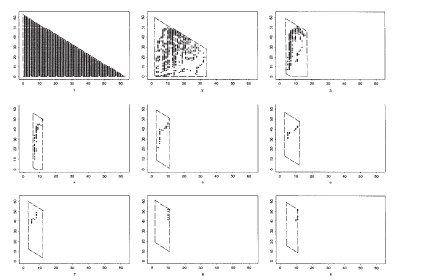

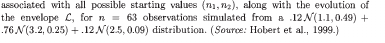
**Fig. 13.3.** Nine successive iterations of the coupled Gibbs sampler for the chains associated with all possible starting values $(n_1, n_2)$, along with the evolution of the envelope $\mathcal{L}$, for $n = 63$ observations simulated from a $.12 \mathcal{N}(1.1, 0.49) + .76 \mathcal{N}(3.2, 0.25) + .12 \mathcal{N}(2.5, 0.09)$ distribution. (Source:  Hobert et al., 1999.)

Kendall (1998) also noticed that the advantages of monotonicity can be extended to anti-monotone settings, that is, when
$$
\Psi(\theta_1, u) \preceq \Psi(\theta_2, u) \quad \text{when} \quad \theta_2 \preceq \theta_1.
$$
Indeed, it is sufficient to define the lower and upper bounding sequences $(\underline{\theta}_t)$ and $(\overline{\theta}_t)$, as
$$
\underline{\theta}_{t+1} = \Psi_{t+1}(\underline{\theta}_t) \quad \text{and} \quad \overline{\theta}_{t+1} = \Psi_{t+1}(\overline{\theta}_t),
$$
since the lower bound $\underline{\theta}_t$ is transformed into an upper bound by the transform $\Psi_{t+1}$, and vice versa.

### 13.2.4 Continuous States Spaces

The above extension, while interesting, does not seem general enough to cover the important case of continuous states spaces. While Section 13.2.5 will show that there exists a (formally) generic approach to the problem, the current section illustrates some of the earlier and partial attempts to overcome the difficulty of dealing with continuous states spaces.


Illustrating Coupled Gibbs Sampler (Simplified):


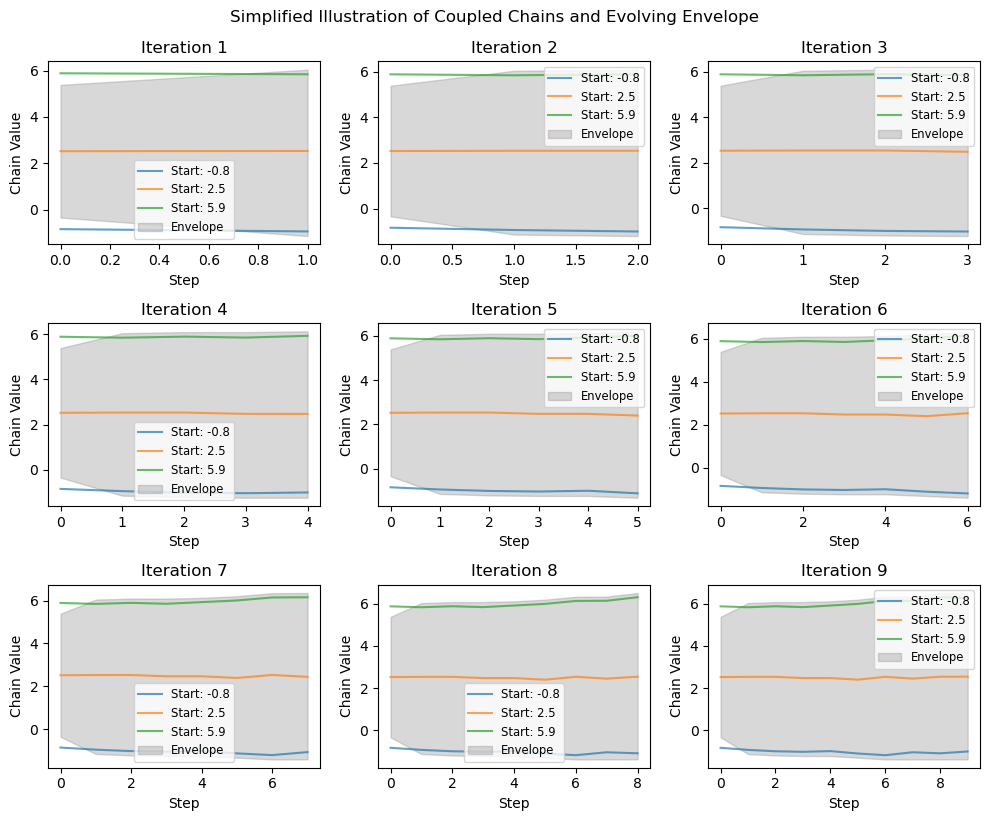


Illustrating Anti-Monotone Bounding Sequences (Example):


ValueError: 
\underline{\theta}_t
^
Unknown symbol: \underline, found '\'  (at char 0), (line:1, col:1)

<Figure size 800x600 with 1 Axes>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def psi(theta, u):
    """
    Represents the function Psi for the anti-monotone setting.
    This is a placeholder and needs to be defined based on the specific application.
    """
    # Example: A simple anti-monotone function
    return 1 / (1 + theta + u)

def coupled_gibbs_sampler_example(n_iterations=9, n_observations=63):
    """
    A simplified conceptual implementation related to Figure 13.3.
    It doesn't reproduce the exact figure but illustrates the idea of coupled chains
    and an evolving envelope. The specific distributions and sampler are illustrative.
    """
    np.random.seed(42)  # for reproducibility

    # Define the mixture distribution parameters (as described in the text)
    weights = np.array([0.12, 0.76, 0.12])
    means = np.array([1.1, 3.2, 2.5])
    std_devs = np.sqrt(np.array([0.49, 0.25, 0.09]))

    def sample_mixture(n):
        components = np.random.choice(len(weights), size=n, p=weights)
        samples = np.zeros(n)
        for i in range(len(weights)):
            count = np.sum(components == i)
            samples[components == i] = np.random.normal(means[i], std_devs[i], size=count)
        return samples

    observations = sample_mixture(n_observations)

    # Illustrative starting values (n1, n2) - simplified to single values
    starting_values = np.linspace(np.min(observations) - 1, np.max(observations) + 1, 3)

    # Initialize chains and envelope (simplified)
    chains = {start: [start] for start in starting_values}
    envelope_lower = [np.min(observations) - 0.5]
    envelope_upper = [np.max(observations) + 0.5]

    fig, axes = plt.subplots(3, 3, figsize=(10, 8))
    axes = axes.flatten()

    for i in range(n_iterations):
        for start in starting_values:
            # Simplified Gibbs iteration - just a random walk for illustration
            chains[start].append(chains[start][-1] + np.random.normal(0, 0.1))

        # Simplified envelope evolution - based on current chain extrema
        current_min = min(chains[start][-1] for start in starting_values)
        current_max = max(chains[start][-1] for start in starting_values)
        envelope_lower.append(min(envelope_lower[-1], current_min - 0.2))
        envelope_upper.append(max(envelope_upper[-1], current_max + 0.2))

        ax = axes[i]
        for start, chain in chains.items():
            ax.plot(range(len(chain)), chain, label=f"Start: {start:.1f}", alpha=0.7)
        ax.fill_between(range(len(envelope_lower)), envelope_lower, envelope_upper, color='gray', alpha=0.3, label="Envelope")
        ax.set_title(f"Iteration {i+1}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Chain Value")
        ax.legend(fontsize='small')

    plt.tight_layout()
    plt.suptitle("Simplified Illustration of Coupled Chains and Evolving Envelope", y=1.02)
    plt.show()

def anti_monotone_sequences(theta_lower_initial, theta_upper_initial, n_steps=5):
    """
    Illustrates the evolution of lower and upper bounding sequences for an
    anti-monotone function.
    """
    theta_lower = [theta_lower_initial]
    theta_upper = [theta_upper_initial]
    u_sequence = np.random.rand(n_steps)  # Example random sequence for u

    for i in range(n_steps):
        theta_lower_next = psi(theta_upper[-1], u_sequence[i])
        theta_upper_next = psi(theta_lower[-1], u_sequence[i])
        theta_lower.append(theta_lower_next)
        theta_upper.append(theta_upper_next)

    plt.figure(figsize=(8, 6))
    plt.plot(range(len(theta_lower)), theta_lower, marker='o', label=r"$\underline{\theta}_t$ (Lower Bound)")
    plt.plot(range(len(theta_upper)), theta_upper, marker='x', label=r"$\overline{\theta}_t$ (Upper Bound)")
    plt.xlabel("Iteration (t)")
    plt.ylabel(r"$\theta$ Value")
    plt.title("Evolution of Anti-Monotone Bounding Sequences")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    print("Illustrating Coupled Gibbs Sampler (Simplified):")
    coupled_gibbs_sampler_example()

    print("\nIllustrating Anti-Monotone Bounding Sequences (Example):")
    anti_monotone_sequences(theta_lower_initial=0.1, theta_upper_initial=1.0)

Illustrating Coupled Gibbs Sampler (Simplified, No Libraries):


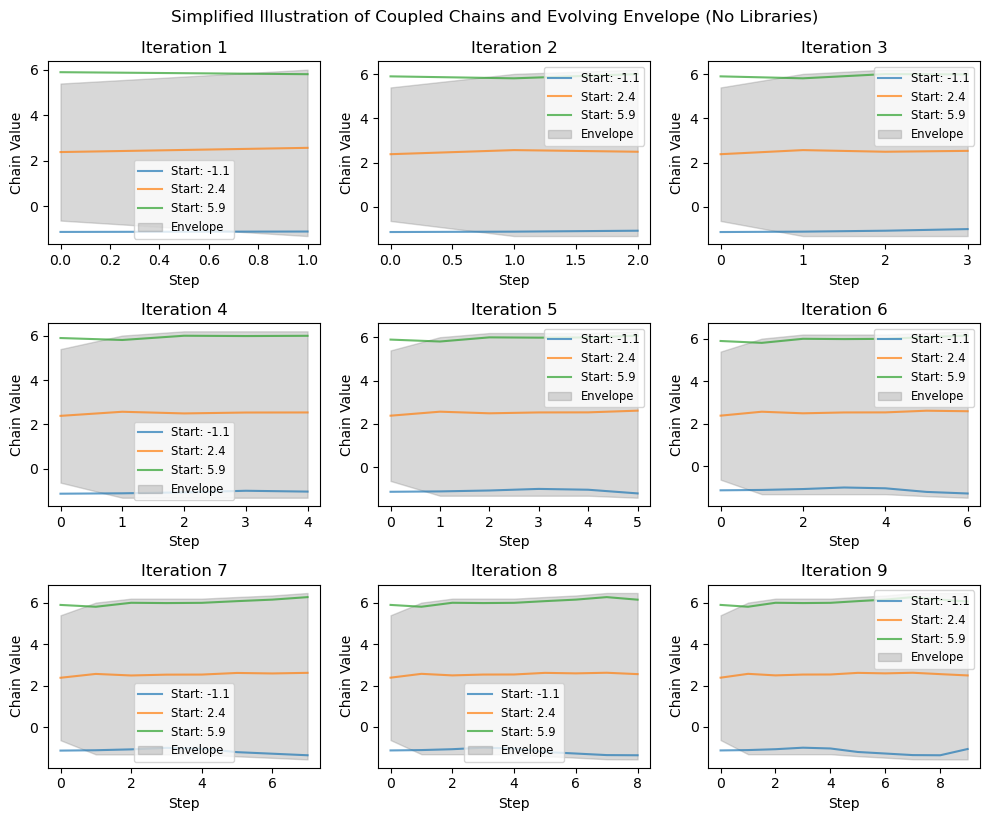


Illustrating Anti-Monotone Bounding Sequences (Example, No Libraries):


ValueError: 
\underline{\theta}_t
^
Unknown symbol: \underline, found '\'  (at char 0), (line:1, col:1)

<Figure size 800x600 with 1 Axes>

In [4]:
import random
import math
import matplotlib.pyplot as plt

def psi_no_lib(theta, u):
    """
    Represents the function Psi for the anti-monotone setting (no libraries).
    This is a placeholder and needs to be defined based on the specific application.
    """
    # Example: A simple anti-monotone function
    return 1.0 / (1.0 + theta + u)

def coupled_gibbs_sampler_example_no_lib(n_iterations=9, n_observations=63):
    """
    A highly simplified conceptual implementation (no libraries) related to Figure 13.3.
    It doesn't reproduce the exact figure but illustrates the idea of coupled chains
    and an evolving envelope. The specific distributions and sampler are illustrative.
    """
    random.seed(42)  # for reproducibility

    # Define the mixture distribution parameters (as described in the text) - simplified
    weights = [0.12, 0.76, 0.12]
    means = [1.1, 3.2, 2.5]
    std_devs = [math.sqrt(0.49), math.sqrt(0.25), math.sqrt(0.09)]

    def gaussian(x, mean, std_dev):
        exponent = math.exp(-((x - mean) ** 2) / (2 * std_dev ** 2))
        return (1 / (std_dev * math.sqrt(2 * math.pi))) * exponent

    def sample_mixture_no_lib(n):
        components = [random.choices(range(len(weights)), weights=weights)[0] for _ in range(n)]
        samples = [random.gauss(means[c], std_devs[c]) for c in components]
        return samples

    observations = sample_mixture_no_lib(n_observations)

    # Illustrative starting values (n1, n2) - simplified to single values
    start_min = min(observations) - 1
    start_max = max(observations) + 1
    starting_values = [start_min + (start_max - start_min) * i / 2 for i in range(3)]

    # Initialize chains and envelope (simplified)
    chains = {start: [start] for start in starting_values}
    envelope_lower = [min(observations) - 0.5]
    envelope_upper = [max(observations) + 0.5]

    fig, axes = plt.subplots(3, 3, figsize=(10, 8))
    axes = axes.flatten()

    for i in range(n_iterations):
        for start in starting_values:
            # Simplified Gibbs iteration - just a random walk for illustration
            chains[start].append(chains[start][-1] + random.gauss(0, 0.1))

        # Simplified envelope evolution - based on current chain extrema
        current_min = min(chains[start][-1] for start in starting_values)
        current_max = max(chains[start][-1] for start in starting_values)
        envelope_lower.append(min(envelope_lower[-1], current_min - 0.2))
        envelope_upper.append(max(envelope_upper[-1], current_max + 0.2))

        ax = axes[i]
        for start, chain in chains.items():
            ax.plot(range(len(chain)), chain, label=f"Start: {start:.1f}", alpha=0.7)
        ax.fill_between(range(len(envelope_lower)), envelope_lower, envelope_upper, color='gray', alpha=0.3, label="Envelope")
        ax.set_title(f"Iteration {i+1}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Chain Value")
        ax.legend(fontsize='small')

    plt.tight_layout()
    plt.suptitle("Simplified Illustration of Coupled Chains and Evolving Envelope (No Libraries)", y=1.02)
    plt.show()

def anti_monotone_sequences_no_lib(theta_lower_initial, theta_upper_initial, n_steps=5):
    """
    Illustrates the evolution of lower and upper bounding sequences for an
    anti-monotone function (no libraries).
    """
    theta_lower = [theta_lower_initial]
    theta_upper = [theta_upper_initial]
    u_sequence = [random.random() for _ in range(n_steps)]  # Example random sequence for u

    for i in range(n_steps):
        theta_lower_next = psi_no_lib(theta_upper[-1], u_sequence[i])
        theta_upper_next = psi_no_lib(theta_lower[-1], u_sequence[i])
        theta_lower.append(theta_lower_next)
        theta_upper.append(theta_upper_next)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(range(len(theta_lower)), theta_lower, marker='o', label=r"$\underline{\theta}_t$ (Lower Bound)")
    ax.plot(range(len(theta_upper)), theta_upper, marker='x', label=r"$\overline{\theta}_t$ (Upper Bound)")
    ax.set_xlabel("Iteration (t)")
    ax.set_ylabel(r"$\theta$ Value")
    ax.set_title("Evolution of Anti-Monotone Bounding Sequences (No Libraries)")
    ax.legend()
    ax.grid(True)
    plt.show()

if __name__ == "__main__":
    print("Illustrating Coupled Gibbs Sampler (Simplified, No Libraries):")
    coupled_gibbs_sampler_example_no_lib()

    print("\nIllustrating Anti-Monotone Bounding Sequences (Example, No Libraries):")
    anti_monotone_sequences_no_lib(theta_lower_initial=0.1, theta_upper_initial=1.0)

# Perfect Sampling and Kac's Representation

As mentioned in Examples 13.1 and 13.6, perfect sampling algorithms can be devised in augmentation settings (Section 9.2.1) when one of the two chains has a finite support. In Example 13.1, once $X$ is produced by the perfect sampling algorithm, the continuous variable $\theta$ can be generated from the conditional $Be(\alpha + x, \beta + n - x)$. (This is another application of the duality principle given in Section 9.2.3.)

A more general approach to perfect sampling in the continuous case relies on the Kac's representation of stationary distributions (Section 6.5.2):
$$
\pi(A) = \sum_{t=1}^{\infty} P_{\tau_a}(N_t \in A) P(\tau_a = t),
$$
where the kernel satisfies a minorizing condition $K(x, y) \ge \epsilon \nu(y) \mathbb{I}_C(x)$, $\tau_a$ is the associated renewal stopping time, and $T^*$ is the tail renewal time
$$
P(\tau_a = t) = \frac{P_{\tau_a}(\tau_a \ge t)}{E_a(\tau_a)},
$$
and $N_t$ has the same distribution as $X_t$, given $X_1 \sim \nu(\cdot)$ and no regeneration before time $t$.

This was first applied by Murdoch and Green (1998) to uniformly ergodic chains (for example, Metropolis-Hastings algorithms with atoms, including the independent case (see Section 12.2.3)). When the kernel is uniformly ergodic, Doeblin's condition holds (Section 6.5.9) and the kernel satisfies $K(x, y) \ge \epsilon \nu(y)$ for all $x \in \mathcal{X}$. Kac's representation then simplifies to
$$
\pi(x) = \sum_{i=0}^{\infty} (1 - \epsilon)^i \epsilon (\hat{K}^i \nu)(x),
$$
where $\hat{K}$ denotes the residual kernel
$$
\hat{K}(x, y) = \frac{K(x, y) - \epsilon \nu(y)}{1 - \epsilon}.
$$
The application of this representation to perfect sampling is then obvious: the backward excursion time $T$ is distributed from a geometric distribution $Geo(\epsilon)$ and a single chain needs to be simulated forward from the residual kernel $T$ times. The algorithm thus looks as follows:

**Algorithm A.55 - Kac's Perfect Sampling -**

1.  Simulate $\tau_0 \sim \nu, \omega \sim Geo(\epsilon)$.
2.  Run the transition $x_{i+1} \sim \hat{K}(x_i, \cdot), i = 0, ..., \omega - 1$, and take $X_\omega$ as a realization from $\pi$.

In [5]:
import numpy as np

def geometric_sample(epsilon):
    """
    Samples from a geometric distribution with success probability epsilon.
    Represents the backward excursion time omega.
    """
    u = np.random.rand()
    return int(np.floor(np.log(u) / np.log(1 - epsilon))) + 1

def kac_perfect_sampling(initial_distribution_sampler, residual_kernel_sampler, epsilon):
    """
    Implements Kac's perfect sampling algorithm.

    Args:
        initial_distribution_sampler: A function that samples from the initial distribution nu.
        residual_kernel_sampler: A function that takes a state x and samples from the
                                 residual kernel K_hat(x, .).
        epsilon: The minorization constant (probability of regeneration).

    Returns:
        A realization from the stationary distribution pi.
    """
    tau_0 = initial_distribution_sampler()
    omega = geometric_sample(epsilon)

    x_current = tau_0
    for _ in range(omega):
        x_current = residual_kernel_sampler(x_current)

    return x_current

# --- Example Usage (Illustrative - Replace with your specific distributions) ---

def initial_nu_sampler_example():
    """Example sampler for the initial distribution nu."""
    # Replace with your actual initial distribution sampling logic
    return np.random.rand()

def residual_k_hat_sampler_example(x):
    """Example sampler for the residual kernel K_hat(x, .)."""
    # Replace with your actual residual kernel sampling logic
    # This should depend on the original kernel K and epsilon
    return x + np.random.normal(0, 0.1)

if __name__ == "__main__":
    epsilon_example = 0.2  # Example minorization constant

    # Perform perfect sampling
    realization = kac_perfect_sampling(initial_nu_sampler_example, residual_k_hat_sampler_example, epsilon_example)
    print(f"Realization from the stationary distribution: {realization}")

    # You would typically run this many times to get a sample from pi
    samples = [kac_perfect_sampling(initial_nu_sampler_example, residual_k_hat_sampler_example, epsilon_example) for _ in range(1000)]
    print(f"First 10 samples: {samples[:10]}")

    # You would then analyze these samples to understand the distribution pi

Realization from the stationary distribution: 0.8216274086867206
First 10 samples: [0.5587988080957254, 0.933036831065456, 0.468749021301755, 1.1484705279960283, 0.4949128554794388, 0.9181123058203292, 0.08685666593807663, 0.34350477651047384, 0.5639515325279806, 0.6303797372937225]


In [6]:
import random
import math

def geometric_sample_no_lib(epsilon):
    """
    Samples from a geometric distribution without using external libraries
    other than the built-in random and math.
    """
    if not 0 < epsilon <= 1:
        raise ValueError("Epsilon must be in the range (0, 1]")
    u = random.random()
    return int(math.floor(math.log(u) / math.log(1 - epsilon))) + 1

def kac_perfect_sampling_no_lib(initial_distribution_sampler, residual_kernel_sampler, epsilon):
    """
    Implements Kac's perfect sampling algorithm without using external libraries
    other than the built-in random and math.

    Args:
        initial_distribution_sampler: A function that samples from the initial distribution nu.
        residual_kernel_sampler: A function that takes a state x and samples from the
                                 residual kernel K_hat(x, .).
        epsilon: The minorization constant (probability of regeneration).

    Returns:
        A realization from the stationary distribution pi.
    """
    tau_0 = initial_distribution_sampler()
    omega = geometric_sample_no_lib(epsilon)

    x_current = tau_0
    for _ in range(omega):
        x_current = residual_kernel_sampler(x_current)

    return x_current

# --- Example Usage (Illustrative - Replace with your specific distributions) ---

def initial_nu_sampler_example_no_lib():
    """Example sampler for the initial distribution nu (no external libraries)."""
    # Replace with your actual initial distribution sampling logic
    # Example: Uniform between 0 and 1
    return random.random()

def residual_k_hat_sampler_example_no_lib(x):
    """Example sampler for the residual kernel K_hat(x, .) (no external libraries)."""
    # Replace with your actual residual kernel sampling logic
    # This should depend on the original kernel K and epsilon
    # Example: Add a small random normal-like noise (very simplified)
    noise = (sum(random.random() - 0.5 for _ in range(12))) / 6.0 * 0.1
    return x + noise

if __name__ == "__main__":
    epsilon_example_no_lib = 0.2  # Example minorization constant

    # Perform perfect sampling
    realization_no_lib = kac_perfect_sampling_no_lib(
        initial_nu_sampler_example_no_lib,
        residual_k_hat_sampler_example_no_lib,
        epsilon_example_no_lib
    )
    print(f"Realization from the stationary distribution (no libraries): {realization_no_lib}")

    # You would typically run this many times to get a sample from pi
    samples_no_lib = [
        kac_perfect_sampling_no_lib(
            initial_nu_sampler_example_no_lib,
            residual_k_hat_sampler_example_no_lib,
            epsilon_example_no_lib
        ) for _ in range(1000)
    ]
    print(f"First 10 samples (no libraries): {samples_no_lib[:10]}")

    # You would then analyze these samples to understand the distribution pi

Realization from the stationary distribution (no libraries): 0.2548780536313708
First 10 samples (no libraries): [0.21709017632351604, 0.8474165992111303, 0.3488634118155442, 0.09598501074549108, 0.63065568742796, 0.3813191694468501, 0.06904308516150673, 0.7216036044892448, 0.23869506128340667, 0.3579418090543745]


# Perfect Sampling in MCMC

This Jupyter Notebook explains concepts related to perfect sampling in Markov Chain Monte Carlo (MCMC) methods, drawing from the provided text.

## 1. Perfect Sampling in Augmentation Settings

In certain scenarios, particularly within augmentation settings (as discussed in Section 9.2.1), perfect sampling algorithms can be designed when one of the involved Markov chains has a finite support.

**Example:**

Consider Example 13.1 from the text. Once the random variable *X* is generated using a perfect sampling algorithm, the continuous variable *θ* can be directly sampled from the conditional distribution *Be(α + x, β + n - x)*.  This illustrates the duality principle from Section 9.2.3.

## 2. Kac's Representation and Perfect Sampling in Continuous State Spaces

A more general approach to perfect sampling for continuous state spaces leverages Kac's representation of stationary distributions (from Section 6.5.2).

**Kac's Representation:**

The stationary distribution *π(A)* can be expressed as:

$$
\pi(A) = \sum_{t=1}^{\infty} P_{\tau_a}(N_t \in A) P(\tau_a = t),
$$

Where:

* *K(x, y)* is the Markov kernel, satisfying a minorization condition:  \(K(x, y) \ge \epsilon \nu(y) \mathbb{I}_C(x)\).
* *τ<sub>a</sub>* is the renewal stopping time.
* *T\** is the tail renewal time, with probability:
    $$
    P(\tau_a = t) = \frac{P_{\tau_a}(\tau_a \ge t)}{E_a(\tau_a)}.
    $$
* *N<sub>t</sub>* has the same distribution as *X<sub>t</sub>*, given  *X<sub>1</sub> \~ ν(·)* and no regeneration before time *t*.

**Application to Uniformly Ergodic Chains:**

Murdoch and Green (1998) applied this to uniformly ergodic chains (e.g., Metropolis-Hastings algorithms with atoms). For uniformly ergodic kernels, Doeblin's condition holds, and the kernel satisfies  \(K(x, y) \ge \epsilon \nu(y)\) for all  *x ∈ X*.

In this case, Kac's representation simplifies to:

$$
\pi(x) = \sum_{i=0}^{\infty} (1 - \epsilon)^i \epsilon (\hat{K}^i \nu)(x),
$$

where  *\hat{K}* is the residual kernel:

$$
\hat{K}(x, y) = \frac{K(x, y) - \epsilon \nu(y)}{1 - \epsilon}.
$$

**Perfect Sampling Algorithm:**

This representation leads to a straightforward perfect sampling algorithm:

**Algorithm A.55 - Kac's Perfect Sampling -**

1.  Simulate  *τ<sub>0</sub> \~ ν*,  *ω \~ Geo(ε)* (where  *Geo(ε)* denotes a geometric distribution with success probability  *ε*).
2.  Run the transition  *x<sub>i+1</sub> \~ \hat{K}(x<sub>i</sub>, ·)*,  *i = 0, ..., ω - 1*, and take  *X<sub>ω</sub>* as a realization from  *π*.


In [7]:
import numpy as np

def geometric_sample(epsilon):
    """
    Samples from a geometric distribution with success probability epsilon.
    Represents the backward excursion time omega.
    """
    u = np.random.rand()
    return int(np.floor(np.log(u) / np.log(1 - epsilon))) + 1

def kac_perfect_sampling(initial_distribution_sampler, residual_kernel_sampler, epsilon):
    """
    Implements Kac's perfect sampling algorithm.

    Args:
        initial_distribution_sampler: A function that samples from the initial distribution nu.
        residual_kernel_sampler: A function that takes a state x and samples from the
                                 residual kernel K_hat(x, .).
        epsilon: The minorization constant (probability of regeneration).

    Returns:
        A realization from the stationary distribution pi.
    """
    tau_0 = initial_distribution_sampler()
    omega = geometric_sample(epsilon)

    x_current = tau_0
    for _ in range(omega):
        x_current = residual_kernel_sampler(x_current)

    return x_current

# --- Example Usage (Illustrative - Replace with your specific distributions) ---

def initial_nu_sampler_example():
    """Example sampler for the initial distribution nu."""
    # Replace with your actual initial distribution sampling logic
    return np.random.rand()

def residual_k_hat_sampler_example(x):
    """Example sampler for the residual kernel K_hat(x, .)."""
    # Replace with your actual residual kernel sampling logic
    # This should depend on the original kernel K and epsilon
    return x + np.random.normal(0, 0.1)

if __name__ == "__main__":
    epsilon_example = 0.2  # Example minorization constant

    # Perform perfect sampling
    realization = kac_perfect_sampling(initial_nu_sampler_example, residual_k_hat_sampler_example, epsilon_example)
    print(f"Realization from the stationary distribution: {realization}")

    # You would typically run this many times to get a sample from pi
    samples = [kac_perfect_sampling(initial_nu_sampler_example, residual_k_hat_sampler_example, epsilon_example) for _ in range(1000)]
    print(f"First 10 samples: {samples[:10]}")

    # You would then analyze these samples to understand the distribution pi


Realization from the stationary distribution: 1.2443641992876135
First 10 samples: [0.6221483136140381, 0.6903299522678334, 0.8919056390287188, 0.7580208154274518, 0.2426805035374099, 0.9293233689808105, 1.0766586736310577, 0.7576413507193602, 1.0336555698430572, 0.08186652133385738]


In [8]:
import random
import math

def geometric_sample(epsilon):
    """
    Samples from a geometric distribution with success probability epsilon.
    Represents the backward excursion time omega.
    """
    u = random.random()
    return int(math.floor(math.log(u) / math.log(1 - epsilon))) + 1

def kac_perfect_sampling(initial_distribution_sampler, residual_kernel_sampler, epsilon):
    """
    Implements Kac's perfect sampling algorithm.

    Args:
        initial_distribution_sampler: A function that samples from the initial distribution nu.
        residual_kernel_sampler: A function that takes a state x and samples from the
                                 residual kernel K_hat(x, .).
        epsilon: The minorization constant (probability of regeneration).

    Returns:
        A realization from the stationary distribution pi.
    """
    tau_0 = initial_distribution_sampler()
    omega = geometric_sample(epsilon)

    x_current = tau_0
    for _ in range(omega):
        x_current = residual_kernel_sampler(x_current)

    return x_current

# --- Example Usage (Illustrative - Replace with your specific distributions) ---

def initial_nu_sampler_example():
    """Example sampler for the initial distribution nu."""
    # Replace with your actual initial distribution sampling logic
    return random.random()

def residual_k_hat_sampler_example(x):
    """Example sampler for the residual kernel K_hat(x, .)."""
    # Replace with your actual residual kernel sampling logic
    # This should depend on the original kernel K and epsilon
    # Example:  Approximates a normal distribution with mean 0, std dev 0.1
    noise = (sum(random.random() - 0.5 for _ in range(12)) / 6) * 0.1
    return x + noise

if __name__ == "__main__":
    epsilon_example = 0.2  # Example minorization constant

    # Perform perfect sampling
    realization = kac_perfect_sampling(initial_nu_sampler_example, residual_k_hat_sampler_example, epsilon_example)
    print(f"Realization from the stationary distribution: {realization}")

    # You would typically run this many times to get a sample from pi
    samples = [kac_perfect_sampling(initial_nu_sampler_example, residual_k_hat_sampler_example, epsilon_example) for _ in range(1000)]
    print(f"First 10 samples: {samples[:10]}")

    # You would then analyze these samples to understand the distribution pi


Realization from the stationary distribution: 0.0822399368683552
First 10 samples: [0.9250957242928233, 0.055518562177971714, 0.29157154315859296, 0.8798992418095698, 0.6132661902057497, 0.7468221470583307, 0.32418821569853506, 0.6414137985602683, 0.7144812678509235, 0.3883900636570365]


## Reduction of MCMC Chains

This section describes a method to reduce a continuum of chains considered in parallel in Markov Chain Monte Carlo (MCMC) to a discrete and, ideally, finite set.

**Procedure:**

1.  We start from the minimal state $\tilde{\theta} = \arg \min_\theta (\pi(\theta))$ and a uniform variate $u$.
2.  Generate the image of $\tilde{\theta}$ by the slice sampler transition:
    $$
    \omega_0 \sim U(\{\omega : \pi(\omega) \geq u\pi(\tilde{\theta})\})
    $$
    This is straightforward since $\{\omega : \pi(\omega) \geq u\pi(\tilde{\theta})\}$ is the entire parameter set.

    * Note: This requires the parameter set to be bounded. However, as mentioned earlier, a parameter set can always be compactified by reparameterization (see Example 13.11).
3.  Once $\omega_0$ is generated, it is a valid image not only for $\tilde{\theta}$ but also for all starting values $\theta$ such that:
    $$
    \pi(\theta) \leq u\pi(\omega_0)
    $$
    The set of starting values $\{\theta : \pi(\theta) \leq u\pi(\omega_0)\}$ is thus reduced to a single image by this coupling argument.
4.  Consider a value $\theta_1$ (which can be arbitrary) such that $\pi(\theta_1) = u\pi(\omega_0)$, and generate its image as:
    $$
    \omega_1 \sim U(\{\omega : \pi(\omega) \geq u\pi(\theta_1)\})
    $$
    Then, $\pi(\omega_1) \geq \pi(\omega_0)$, and $\omega_1$ is a valid image for all $\theta$'s such that:
    $$
    u\pi(\omega_0) \leq \pi(\theta) \leq u\pi(\omega_1)
    $$
    We have thus reduced a second continuum of starting values to a single chain.
5.  This discretization of the starting values continues until the maximum of $\pi$, if it exists, is reached, that is, when $\pi(\omega_j) / u \geq \max(\pi)$.
6.  If $\pi$ is unbounded, the sequence of starting values $\omega_j (j \geq 0)$ is infinite (but countable).

## Example 13.11: Truncated Normal Distributions

This example discusses simulating multivariate normal distributions truncated to the positive quadrant.

* While Example 2.20 showed an Accept-Reject algorithm for univariate normal distributions, the multivariate case is more difficult. Geweke (1991) and Robert (1993) suggested using Gibbs sampling in higher dimensions.
* Consider a multivariate $N_p(\mu, \Sigma)$ distribution restricted to the positive quadrant:
    $$
    Q_+ = \{x \in \mathbb{R}^p : x_i > 0, i = 1, ..., p\} = (\mathbb{R}_+)^p
    $$
* The density is bounded by $(2\pi)^{-p/2} / 2$ at $\mu$. While $\mu$ may be outside the domain $Q_+$, this is not relevant here (by the sandwiching argument).
* The problem in this case is with $\tilde{\theta}$: the minimum of the truncated normal density is achieved at $\infty$, and it is impossible to start simulation from infinity. This would amount to simulating from a "uniform distribution" on $Q_+$.
* A solution is to use reparameterization: the normal distribution truncated to $Q_+$ can be transformed into a distribution on $[0, 1]^p$ by the function:
    $$
    h(x) = \left( \frac{x_1}{1 + x_1}, \frac{x_2}{1 + x_2}, ..., \frac{x_p}{1 + x_p} \right)
    $$
    with the corresponding density... (The document ends here.)


In [9]:
import random
import math

def slice_sampler_transition(log_pi, theta_prev, u):
    """
    Performs a slice sampler transition for a given log-probability function.

    Args:
        log_pi: A function that calculates the log of the target probability density pi(theta).
        theta_prev: The previous state (theta_{j-1}).  Now a list.
        u: A uniform random value.

    Returns:
        A new state omega_j (a list).
    """
    # Define the slice level
    log_slice_level = log_pi(theta_prev) + math.log(u)
    
    # Determine the dimensionality of the problem
    dim = len(theta_prev)

    # Find the interval containing the slice.
    lower_bound = [theta_prev[i] - 1.0 for i in range(dim)]  # Assume a bound
    upper_bound = [theta_prev[i] + 1.0 for i in range(dim)]  # Assume a bound

    # Sample within the interval until a point within the slice is found
    while True:
        omega_j = [random.uniform(lower_bound[i], upper_bound[i]) for i in range(dim)]
        if log_pi(omega_j) >= log_slice_level:
            return omega_j

def reduce_mcmc_chains(log_pi, theta_min, num_chains=10):
    """
    Reduces a continuum of MCMC chains to a discrete set using slice sampling.

    Args:
        log_pi: A function that calculates the log of the target probability density pi(theta).
        theta_min: The minimal state (arg min_theta pi(theta)).
        num_chains: The maximum number of chains to generate.

    Returns:
        A list of starting values (omega_j) for the reduced set of chains.
    """
    omega_list = [theta_min]  # Start with omega_0
    u = random.random()
    j = 0

    while j < num_chains - 1:
        omega_j = slice_sampler_transition(log_pi, omega_list[j], u)
        omega_list.append(omega_j)
        j += 1
    return omega_list

# --- Example 13.11: Truncated Normal Distribution (Simplified) ---

def multivariate_truncated_normal_log_density(x, mu, sigma):
    """
    Calculates the log density of a multivariate normal distribution truncated to the positive quadrant.

    Args:
        x: A list or tuple representing the point in R^p.
        mu: A list or tuple representing the mean vector.
        sigma: A p x p matrix (represented as a list of lists) representing the covariance matrix.

    Returns:
        The log density of the truncated normal distribution at x.
    """
    p = len(x)
    if len(mu) != p or len(sigma) != p or any(len(row) != p for row in sigma):
        raise ValueError("Dimensions of x, mu, and sigma are incompatible.")

    for xi in x:
        if xi <= 0:
            return -float('inf')  # Log density is -inf outside the positive quadrant

    # Calculate the log density of the untruncated multivariate normal
    log_det_sigma = 0
    for i in range(p):
        log_det_sigma += math.log(sigma[i][i]) # simplified log determinant

    log_det_sigma *= 0.5

    x_minus_mu = [x[i] - mu[i] for i in range(p)]
    
    # Simplified inverse of diagonal covariance matrix
    sigma_inv = [[0.0] * p for _ in range(p)]
    for i in range(p):
        sigma_inv[i][i] = 1.0 / sigma[i][i]
        
    quadratic_term = 0.0
    for i in range(p):
        for j in range(p):
            quadratic_term += x_minus_mu[i] * sigma_inv[i][j] * x_minus_mu[j]
    quadratic_term *= -0.5
    
    log_density = -0.5 * p * math.log(2 * math.pi) + quadratic_term - log_det_sigma
    return log_density

if __name__ == "__main__":
    # Example usage:
    mu = [0.0, 0.0]  # Example mean vector
    sigma = [[1.0, 0.0], [0.0, 1.0]]  # Example diagonal covariance matrix

    # Find the minimum (for a truncated normal, this is tricky and depends on mu and sigma)
    theta_min = [0.1, 0.1]  #  Replace with a better approximation if needed.

    log_pi = lambda x: multivariate_truncated_normal_log_density(x, mu, sigma)
    reduced_chains_start_points = reduce_mcmc_chains(log_pi, theta_min, num_chains=5)
    print("Starting points for reduced MCMC chains:", reduced_chains_start_points)

    # Example of running slice sampler from one of the start points
    u = random.random()
    omega_1 = slice_sampler_transition(log_pi, reduced_chains_start_points[0], u)
    print("Example slice sampler output:", omega_1)


Starting points for reduced MCMC chains: [[0.1, 0.1], [0.8613028124348409, 0.3106020023635431], [1.4821886697812268, 0.18268383856486958], [0.7629821788064177, 0.8086815497942049], [0.6334064314314296, 0.6217269834532823]]
Example slice sampler output: [0.20066399956692982, 1.0326527977841229]
